In [50]:
import pandas as pd
import numpy as np
import os
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv("./data.csv",converters={'CustomerID':str})
df['InvoiceDate']=df.InvoiceDate.astype(np.str).str.slice(0,10) #.str.replace('-','')
df.InvoiceDate=pd.to_datetime(df.InvoiceDate)

### 將日期轉成當月第1天(BillMonth)，以便作月統計

In [52]:
def monthly(x):
    return dt.datetime(x.year, x.month, 1)
df['BillMonth'] = df['InvoiceDate'].apply(monthly)

### 找出每一個客戶第一次購買日期(CohortMonth)

In [53]:
g = df.groupby('CustomerID')['BillMonth']
df['CohortMonth'] = g.transform('min')
df.head()

,CustomerID,InvoiceNo,InvoiceDate,Total_Price,BillMonth,CohortMonth
0,17850,536365.0,2010-12-01,15.30,2010-12-01,2010-12-01
1,17850,536365.0,2010-12-01,20.34,2010-12-01,2010-12-01
2,17850,536365.0,2010-12-01,22.00,2010-12-01,2010-12-01
3,17850,536365.0,2010-12-01,20.34,2010-12-01,2010-12-01
4,17850,536365.0,2010-12-01,20.34,2010-12-01,2010-12-01


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361878 entries, 0 to 361877
Data columns (total 6 columns):
CustomerID     361878 non-null object
InvoiceNo      354345 non-null float64
InvoiceDate    361878 non-null datetime64[ns]
Total_Price    361878 non-null float64
BillMonth      361878 non-null datetime64[ns]
CohortMonth    361878 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(2), object(1)
memory usage: 16.6+ MB


### 計算每一筆交易購買日期與第一次購買日期之差

In [55]:
def get_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [56]:
billYear, billMonth = get_int(df, 'BillMonth')
cohortYear, cohortMonth = get_int(df, 'CohortMonth')
diffYear = billYear - cohortYear
diffMonth = billMonth - cohortMonth
df['Month_Index'] = diffYear * 12 + diffMonth + 1

### 產生 Cohort Analysis 表格

In [57]:
g = df.groupby(['CohortMonth', 'Month_Index'])
cohortData = g['CustomerID'].apply(pd.Series.nunique).reset_index()
cohortCounts = cohortData.pivot(index = 'CohortMonth', columns = 'Month_Index', values = 'CustomerID')
cohortSizes = cohortCounts.iloc[:, 0]
retention = cohortCounts.divide(cohortSizes, axis = 0) * 100
retention.round(2)

Month_Index,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.97,33.41,37.77,35.36,39.61,37.54,34.90,35.13,39.72,36.74,49.25,27.32
2011-01-01,100.0,23.20,27.90,24.59,34.25,29.28,26.24,25.97,31.49,35.08,36.19,14.92,NaN
2011-02-01,100.0,25.07,19.17,28.02,28.32,25.37,25.96,28.32,27.73,31.27,9.73,NaN,NaN
2011-03-01,100.0,19.36,26.23,21.57,23.28,17.16,26.23,23.77,29.17,9.31,NaN,NaN,NaN
2011-04-01,100.0,22.46,22.10,21.74,20.65,23.19,23.19,26.45,8.33,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.02,17.06,17.06,21.43,23.81,26.59,9.92,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,21.26,16.43,24.64,25.60,32.37,9.66,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.35,19.19,23.26,27.91,11.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,26.43,22.86,25.71,13.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 作圖

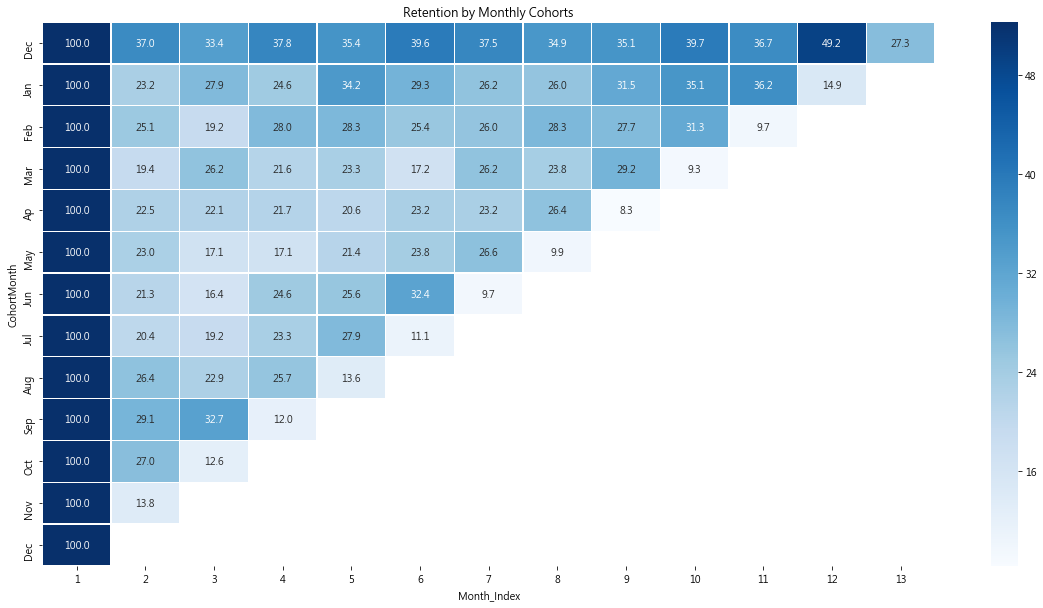

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

month_list = ["Dec", "Jan", "Feb", "Mar", "Ap", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.figure(figsize = (20,10))
plt.title('Retention by Monthly Cohorts')
sns.heatmap(retention.round(2), annot = True, cmap = "Blues", vmax = list(retention.max().sort_values(ascending = False))[1]+3, fmt = '.1f', linewidth = 0.3, yticklabels=month_list)
plt.show()